In [19]:
import argparse
import importlib

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
#import torchvision.datasets as datasets
import mnist; importlib.reload(mnist)
import torchvision.transforms as transforms

In [4]:
parser = {
    "batch_size": 128,
    "epochs": 10,
    "no_cuda": False,
    "seed": 7,
    "log_interval": 10,
}

args = argparse.Namespace(**parser)
args.cuda = not args.no_cuda and torch.cuda.is_available()

In [5]:
args.cuda

True

In [7]:
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

In [23]:
kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
train_loader = DataLoader(
    mnist.MNIST('../data', train=True, download=True,
                transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(
    mnist.MNIST('../data', train=False,
                transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True, **kwargs)

Processing...
Done!


In [24]:
784**0.5

28.0

In [25]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400) # image size = 28x28
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if args.cuda:
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3)) # sigmoid force output in (0,1)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

In [26]:
model = VAE()
if args.cuda:
    model.cuda()

In [33]:
reconstruction_function = nn.BCELoss()
reconstruction_function.size_average = False

In [34]:
def loss_function(recon_x, x, mu, logvar):
    BCE = reconstruction_function(recon_x, x)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)

    return BCE + KLD

In [35]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [36]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        if args.cuda:
            data = data.cuda()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data[0] / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [37]:
def test(epoch):
    model.eval()
    test_loss = 0
    for data, _ in test_loader:
        if args.cuda:
            data = data.cuda()
        data = Variable(data, volatile=True)
        recon_batch, mu, logvar = model(data)
        test_loss += loss_function(recon_batch, data, mu, logvar).data[0]

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [38]:
for epoch in range(1, args.epochs + 1):
    train(epoch)
    test(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 549.272766
Train Epoch: 1 [1280/60000 (2%)]	Loss: 309.734894
Train Epoch: 1 [2560/60000 (4%)]	Loss: 236.502090
Train Epoch: 1 [3840/60000 (6%)]	Loss: 219.546692
Train Epoch: 1 [5120/60000 (9%)]	Loss: 219.768967
Train Epoch: 1 [6400/60000 (11%)]	Loss: 206.733002
Train Epoch: 1 [7680/60000 (13%)]	Loss: 205.604736
Train Epoch: 1 [8960/60000 (15%)]	Loss: 194.939911
Train Epoch: 1 [10240/60000 (17%)]	Loss: 190.394043
Train Epoch: 1 [11520/60000 (19%)]	Loss: 188.267822
Train Epoch: 1 [12800/60000 (21%)]	Loss: 178.500061
Train Epoch: 1 [14080/60000 (23%)]	Loss: 168.829834
Train Epoch: 1 [15360/60000 (26%)]	Loss: 166.308289
Train Epoch: 1 [16640/60000 (28%)]	Loss: 161.739166
Train Epoch: 1 [17920/60000 (30%)]	Loss: 169.172302
Train Epoch: 1 [19200/60000 (32%)]	Loss: 167.673874
Train Epoch: 1 [20480/60000 (34%)]	Loss: 159.213394
Train Epoch: 1 [21760/60000 (36%)]	Loss: 162.529449
Train Epoch: 1 [23040/60000 (38%)]	Loss: 152.397125
Train Epoch: 1 [24320/60000 

In [85]:
for data, _ in test_loader:
    break

In [86]:
if args.cuda:
    data = data.cuda()

data = Variable(data, volatile=True)
recon_batch, mu, logvar = model(data)
recon = recon_batch.view(-1, 1, 28, 28)

In [87]:
%matplotlib inline
import matplotlib.pyplot as plt

In [90]:
sample = data.data[0, 0].cpu().numpy()
recon_sample = recon.data[0,0].cpu().numpy()

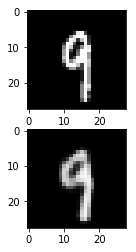

In [91]:
plt.subplot(211)
plt.imshow(sample, vmin=0, vmax=1, cmap="gray")
plt.subplot(212)
plt.imshow(recon_sample, vmin=0, vmax=1, cmap="gray")